<a href="https://colab.research.google.com/github/CharlaChai/COMBINE_workshop/blob/main/mIF_workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Graph construction via SPACE-GM

1. Construct cellular graphs with expression, vorinoi inputs
2. Construct `CellularGraphDataset` and attach node-level / graph-level tasks
3. Initialize a Graph Neural Network (GNN) according to the prediction tasks
4. Train the GNN by randomly sampling subgraphs
5. Evaluate the GNN on node-level / graph-level tasks

In [2]:
import torch
print(torch.__version__)
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-2.6.0+cu124.html


2.6.0+cu124
Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 114.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 129.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 105.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 68.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.4 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')
# %cd /content/drive/MyDrive
# !mkdir mIF_workshop_COMBINE_APES
# %cd mIF_workshop_COMBINE_APES
# !git clone https://gitlab.com/enable-medicine-public/space-gm.git
%cd /content/drive/MyDrive/mIF_workshop_COMBINE_APES/space-gm/
!python setup.py install

Mounted at /content/drive
/content/drive/MyDrive/mIF_workshop_COMBINE_APES/space-gm
running install
/usr/local/lib/python3.11/dist-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer or other
        standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        ********************************************************************************

!!
  self.initialize_options()
/usr/local/lib/python3.11/dist-packages/setuptools/_distutils/cmd.py:66: EasyInstallDeprecationWarning: easy_install command is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` and ``easy_install``.
        Instead, use p

In [4]:
import spacegm


In [5]:
dataset_root = '/content/drive/MyDrive/mIF_workshop_COMBINE_APES'
import os, sys
os.chdir(dataset_root)
# print(sys.version)
import warnings
warnings.filterwarnings("ignore")

from glob import glob
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import torch
import torch.nn as nn
from graph_construction import *
import importlib
import pickle
import gzip
from matplotlib.lines import Line2D
from sklearn.metrics import roc_auc_score, roc_curve


------------
## Step 1: Construct Cellular Graphs

We first construct cellular graphs as `networkx.Graph` using raw inputs including cell coordinates, cell types, biomarker expression, etc.

We provided some example files under `mIF_workshop_COMBINE_APES`:

In [6]:
preprocess_root = os.path.join(dataset_root, 'preprocess/')
nx_graph_root = os.path.join(dataset_root, 'GNN_data/')
fig_save_root = os.path.join(dataset_root, 'figures/')
model_save_root = os.path.join(dataset_root, 'model/')
list_path = [preprocess_root, nx_graph_root, fig_save_root, model_save_root]
for path in list_path:
    os.makedirs(path, exist_ok=True)
    print(path)

/content/drive/MyDrive/mIF_workshop_COMBINE_APES/preprocess/
/content/drive/MyDrive/mIF_workshop_COMBINE_APES/GNN_data/
/content/drive/MyDrive/mIF_workshop_COMBINE_APES/figures/
/content/drive/MyDrive/mIF_workshop_COMBINE_APES/model/


In [7]:
#### paths of input files
graph_label_file = os.path.join(preprocess_root, "CellNeigh_prognosis_file_140TMAs.csv")
feature_file = os.path.join(preprocess_root + 'features_mean_clr_all.pkl')
voronoi_polygons_file = os.path.join(preprocess_root + 'voronoi_polygons_all.pkl')
points_file = os.path.join(preprocess_root + 'points_all.npz')

In [8]:
#### region id, 70, _A, _B
region_ids = []
for r in range(70):
    region_id_A = f'reg{r+1:03d}_A'  # Formats the number with zero-padding to 3 digits
    region_ids.append(region_id_A)    # Append the region ID with '_A'

    region_id_B = f'reg{r+1:03d}_B'   # Formats the number with zero-padding to 3 digits
    region_ids.append(region_id_B)    # Append the region ID with '_B'

In [9]:
### import input files
with open(voronoi_polygons_file, 'rb') as f:
    voronoi_polygons_all = pickle.load(f)

with open(feature_file, 'rb') as f:
    features_mean_all = pickle.load(f)

### load and access numpy.array
points_all = np.load(points_file)
points_all = [points_all[f'arr_{i}'] for i in range(len(points_all.files))]

In [10]:
### checking
print(f'are the numbers of samples the same in the input files: {len(voronoi_polygons_all[1]) == len(features_mean_all[1]) == len(points_all[1])}')
print(len(points_all[0]))
print(len(features_mean_all[69]))
# points_all[0].any() == 'Nan'


are the numbers of samples the same in the input files: True
1164
2266


### A networkx.graph can be constructed using the inputs above

Processing reg001_A
markers of features Index(['CELL_ID', 'region_id', 'X', 'Y', 'SIZE', 'CELL_TYPE',
       'neighborhood name', 'BM-CD44', 'BM-FOXP3', 'BM-CD8', 'BM-p53',
       'BM-GATA3', 'BM-CD45', 'BM-T-bet', 'BM-beta-catenin', 'BM-HLA-DR',
       'BM-PD-L1', 'BM-Ki67', 'BM-CD45RA', 'BM-CD4', 'BM-CD21', 'BM-MUC-1',
       'BM-CD30', 'BM-CD2', 'BM-Vimentin', 'BM-CD20', 'BM-LAG-3',
       'BM-Na-K-ATPase', 'BM-CD5', 'BM-IDO-1', 'BM-Cytokeratin', 'BM-CD11b',
       'BM-CD56', 'BM-aSMA', 'BM-BCL-2', 'BM-CD25', 'BM-CD11c', 'BM-PD-1',
       'BM-Granzyme B', 'BM-EGFR', 'BM-VISTA', 'BM-CD15', 'BM-ICOS',
       'BM-Synaptophysin', 'BM-GFAP', 'BM-CD7', 'BM-CD3', 'BM-Chromogranin A',
       'BM-CD163', 'BM-CD45RO', 'BM-CD68', 'BM-CD31', 'BM-Podoplanin',
       'BM-CD34', 'BM-CD38', 'BM-CD138', 'BM-CDX2', 'BM-Collagen IV',
       'BM-CD194', 'BM-MMP9', 'BM-CD71', 'BM-CD57', 'BM-MMP12'],
      dtype='object')
Processing reg001_B
markers of features Index(['CELL_ID', 'region_id', 'X', 'Y', 'S

<Figure size 640x480 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

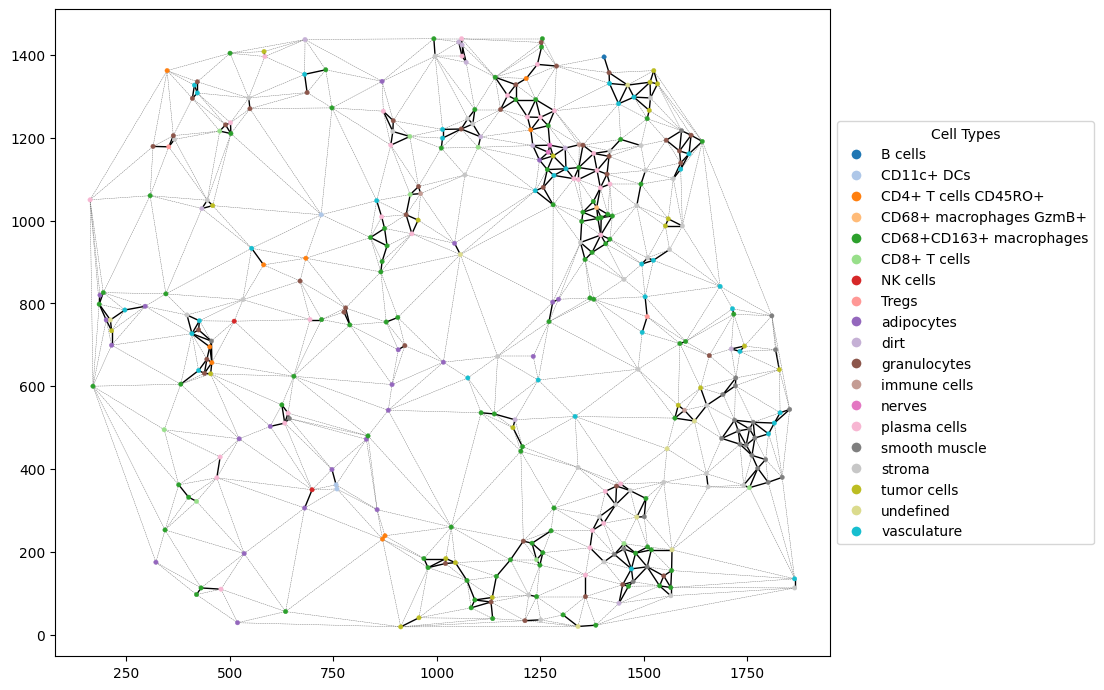

In [11]:
construct_cellular_graph(fig_save_root,nx_graph_root,region_ids[:2], voronoi_polygons_all, features_mean_all)

In [12]:
### load graph files
graph_outputs = [
    os.path.join(nx_graph_root, f'G_{region_id}.gpkl')
    for region_id in region_ids
]

G_all = []
for graph_output in graph_outputs[:10]:
    print (graph_output)
    with open(graph_output, 'rb') as f:
        G = pickle.load(f)
    G_all.append(G)


/content/drive/MyDrive/mIF_workshop_COMBINE_APES/GNN_data/G_reg001_A.gpkl
/content/drive/MyDrive/mIF_workshop_COMBINE_APES/GNN_data/G_reg001_B.gpkl
/content/drive/MyDrive/mIF_workshop_COMBINE_APES/GNN_data/G_reg002_A.gpkl
/content/drive/MyDrive/mIF_workshop_COMBINE_APES/GNN_data/G_reg002_B.gpkl
/content/drive/MyDrive/mIF_workshop_COMBINE_APES/GNN_data/G_reg003_A.gpkl
/content/drive/MyDrive/mIF_workshop_COMBINE_APES/GNN_data/G_reg003_B.gpkl
/content/drive/MyDrive/mIF_workshop_COMBINE_APES/GNN_data/G_reg004_A.gpkl
/content/drive/MyDrive/mIF_workshop_COMBINE_APES/GNN_data/G_reg004_B.gpkl
/content/drive/MyDrive/mIF_workshop_COMBINE_APES/GNN_data/G_reg005_A.gpkl
/content/drive/MyDrive/mIF_workshop_COMBINE_APES/GNN_data/G_reg005_B.gpkl


The function `construct_cellular_graph` also generates some visualisations for each region, stored under `figures` folder.

Here is an example:

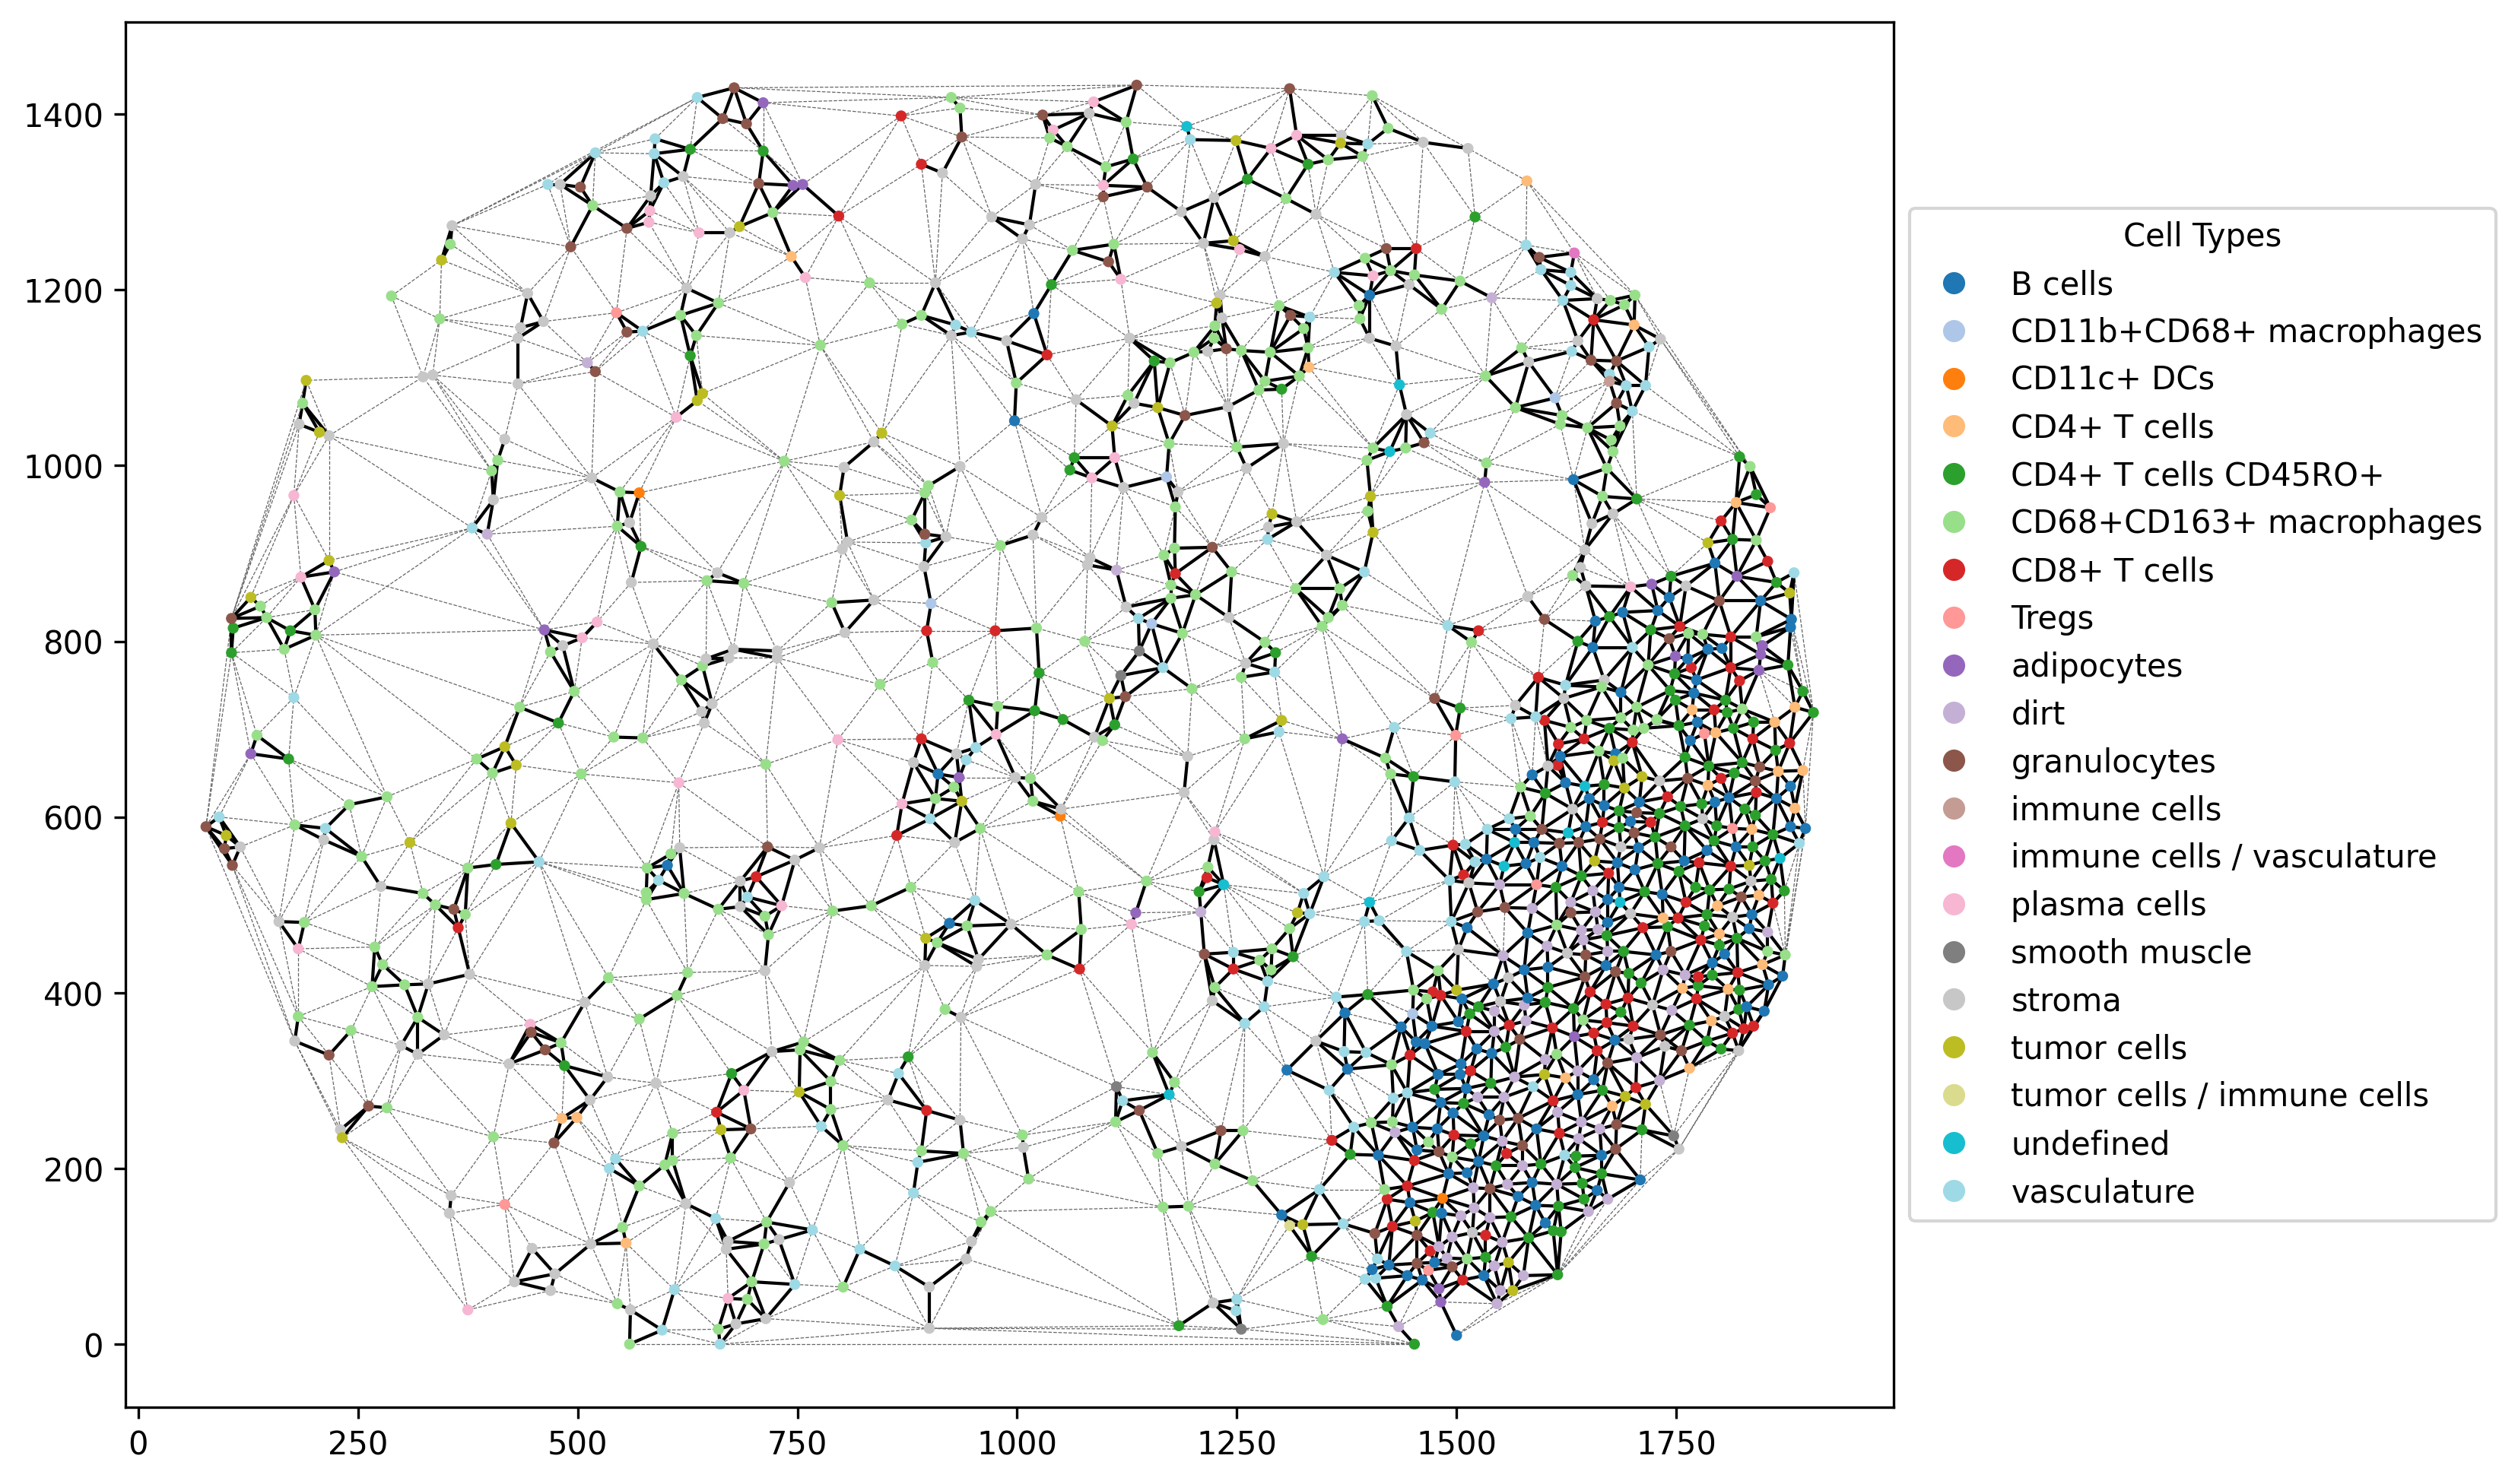

In [13]:
# Visualisation of cellular graph
from IPython.display import Image
graph_img = os.path.join(fig_save_root+'reg001_A_graph.png')
pil_img = Image(filename=graph_img)
display(pil_img)

------------
## Step 2: Construct `CellularGraphDataset`

`CellularGraphDataset` will be the major data container used in model training and evaluation. This object also handles all the featurization, subgraph sampling, and other necessary functionalities for SPACE-GM.

We previously saved all regions as networkx graphs, now we initialize the dataset object using these graph files

In [14]:
dataset_kwargs = {
    'transform': [],
    'pre_transform': None,
    'raw_folder_name': 'GNN_data',  # is the folder where we saved nx graphs
    'processed_folder_name': 'tg_intst_clr',  # processed dataset files will be stored here

    'node_features': ["cell_type", "SIZE", "biomarker_expression", "neighborhood_composition", "center_coord"],
    'edge_features': ["edge_type", "distance"],

    'subgraph_size': 3,  # indicating we want to sample 3-hop subgraphs from these regions (for training/inference), this is a core parameter for SPACE-GM.
    'subgraph_source': 'on-the-fly',
    'subgraph_allow_distant_edge': True,
    'subgraph_radius_limit': 200.,

}
feature_kwargs = {
    "biomarker_expression_process_method": "raw",
    "neighborhood_size": 10,
}
dataset_kwargs.update(feature_kwargs)

In [25]:
dataset = spacegm.data.CellularGraphDataset(dataset_root, **dataset_kwargs)

The full cellular graph for each region in the dataset can be accessed using the class method `get_full`:

In [16]:
i = 0
dataset.get_full(i)

Data(x=[1160, 88], edge_index=[2, 6884], edge_attr=[6884, 2], num_nodes=1160, region_id='reg001_A', component_id=0)

And the n-hop (n=3 in this example) subgraph of region `i` around its center node `j` can be accessed using the class method `get_subgraph`:

In [17]:
i = 0
j = 1034
dataset.get_subgraph(i, j)

Data(x=[42, 88], edge_index=[2, 204], edge_attr=[204, 2], center_node_index=35, original_center_node=1034, num_nodes=42, region_id='reg001_A', component_id=0)

By default, indexing the dataset object will yield an n-hop subgraph around a randomly picked center node (see class method `pick_center`) in the specified region:

In [26]:
len(dataset)
dataset[0]

Data(x=[38, 88], edge_index=[2, 180], edge_attr=[180, 2], center_node_index=13, original_center_node=482, num_nodes=38, region_id='reg001_A', component_id=0)

There is also a quick plotting functions for subgraphs: `plot_subgraph`

(np.float64(1551.6), np.float64(1736.4), np.float64(276.6), np.float64(461.4))

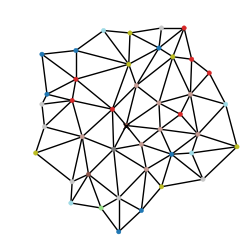

In [19]:
i = 0
j = 1034

plt.figure(figsize=(3, 3))
dataset.plot_subgraph(i, j)
plt.axis('off')

<br/>

During training, due to the high throughput of data streaming, on-the-fly calculation of subgraph might be slow. To speed up data loading, we will save all subgraphs to chunk files first and load them during training/inference.

In [20]:
# dataset.save_all_subgraphs_to_chunk()

In [ ]:
import time

# dataset.clear_cache()
# dataset.set_subgraph_source('on-the-fly') # Can also be set through the `subgraph_source` argument
t0 = time.time()
for _ in range(5000):
    d = dataset[0]
t1 = time.time()
print("Sampling 5000 subgraphs on-the-fly took %.2f seconds" % (t1 - t0))

# dataset.clear_cache()
# dataset.set_subgraph_source('chunk_save')
t0 = time.time()
for _ in range(5000):
    d = dataset[0]
t1 = time.time()
print("Loading 5000 subgraphs from chunk save took %.2f seconds" % (t1 - t0))


<br/>

Transformers will be used to mask features, add node-level and graph-level tasks, etc.

In [31]:
transformers = [
    # `AddCenterCellType` will add `node_y` attribute to the subgraph for node-level prediction task
    # In this task we will mask the cell type of the center cell (replace it by a placeholder cell type)
    # and use its neighborhood to predict the true cell type
    spacegm.AddCenterCellType(dataset),
    # `AddGraphLabel` will add `graph_y` and `graph_w` attributes to the subgraph for graph-level prediction task
    spacegm.AddGraphLabel(graph_label_file, tasks=['OS_status']),
    # Transformer `FeatureMask` will zero mask all feature items not included in its argument
    # In this tutorial we perform training/inference using cell types and center cell's size feature
    # Note that `center_coord` should NOT be used as node features
    spacegm.FeatureMask(dataset, use_center_node_features=['cell_type', 'SIZE'], use_neighbor_node_features=['cell_type']),
]

dataset.set_transforms(transformers)

------

### Step 3 Initialise a Graph Neural Network (GNN)

Now we construct a graph neural network for predicting `survival_status`.

The graph neural network will be composed of 3 parts:
1. The backbone GNN with specified number of graph convolutional layers
2. A node task prediction module if there are node-level tasks defined, this module will be constructed based on the node embedding of the center node
3. A graph task prediction module if there are graph-level tasks defined, this module will be constructed based on the graph-pooled embedding of all the nodes

In [32]:
model_kwargs = {
    'num_layer': dataset.subgraph_size,  # same number of layers as number of hops in the subgraphs
    'num_node_type': len(dataset.cell_type_mapping) + 1,  # number of embeddings for different cell types (plus one placeholder cell type)
    'num_feat': dataset[0].x.shape[1] - 1,  # exclude the cell type column
    'emb_dim': 512,
    'num_node_tasks': len(dataset.cell_type_mapping),  # A multi-class classification task: predicting center cell type
    'num_graph_tasks': 1,  # a binary classification task
    'node_embedding_output': 'last',
    'drop_ratio': 0.25,
    'graph_pooling': "max",
    'gnn_type': 'gin',
}

model = spacegm.GNN_pred(**model_kwargs)
device = 'cuda'

# model_folder = 'GIN_public_intst_clr'
# model_path = os.path.join(model_save_root, model_folder, 'model_save_553.pt')
# model.load_state_dict(torch.load(model_path))

display(model)

GNN_pred(
  (gnn): GNN(
    (x_embedding): Embedding(29, 512)
    (feat_embedding): Linear(in_features=87, out_features=512, bias=True)
    (gnns): ModuleList(
      (0-2): 3 x GINConv()
    )
    (batch_norms): ModuleList(
      (0-2): 3 x BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (graph_pred_module): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=512, out_features=1, bias=True)
  )
  (node_pred_module): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=512, out_features=28, bias=True)
  )
)

------

### Step 4 Train the GNN

GNNs in SPACE-GM are trained using n-hop subgraphs, see `data.SubgraphSampler` for details.

In this tutorial we specified one node-level task (predicting center cell type) and one graph-level task (predicting binary survival status), each task will have a specific loss function.


In [34]:
train_kwargs = {
    'batch_size': 64,
    'lr': 0.001,
    'graph_loss_weight': 1.0,  # Weight of graph task loss relative to node task loss
    'num_iterations': 100,  # In this demo we only train for 50 iterations/batches

    # Loss functions
    'node_task_loss_fn': nn.CrossEntropyLoss(),
    'graph_task_loss_fn': spacegm.models.BinaryCrossEntropy(),

    # Evaluation during training
    'evaluate_fn': [spacegm.train.evaluate_by_sampling_subgraphs, spacegm.train.evaluate_by_full_graph, spacegm.train.save_model_weight],
    'evaluate_freq': 10,  # Evaluate the model every 10 iterations
}

On-the-fly evaluation of model performances is included in the training pipeline:

In [37]:
evaluate_kwargs = {
    'node_task_evaluate_fn': spacegm.inference.cell_type_prediction_evaluate_fn,
    'graph_task_evaluate_fn': spacegm.inference.graph_classification_evaluate_fn,
    'full_graph_node_task_evaluate_fn': spacegm.inference.full_graph_cell_type_prediction_evaluate_fn,
    'full_graph_graph_task_evaluate_fn': spacegm.inference.full_graph_graph_classification_evaluate_fn,
    'num_eval_iterations': 300,
    'score_file': os.path.join(model_save_root, 'space-gm_ROCAUC_score.txt'),
    'model_folder': model_save_root
}
train_kwargs.update(evaluate_kwargs)

Run training:

In [38]:
# Check if CUDA is available and set the device accordingly
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

model = spacegm.train.train_subgraph(
    model,
    dataset,
    device,
    **train_kwargs)

Using device: cuda
Finished iterations 10
Finished iterations 20
Finished iterations 30
Finished iterations 40
Finished iterations 50
Finished iterations 60
Finished iterations 70
Finished iterations 80
Finished iterations 90
Finished iterations 100


Evaluation metrics during training are saved in the specified score file:

In [39]:
with open(evaluate_kwargs['score_file'], 'r') as f:
    for line in f.readlines():
        print(line)

Eval-Subgraph,Train,node-score,0.040,0.040,0.117,0.185,graph-score,0.651

Eval-Full-Graph,Train,node-score,0.063,0.020,0.338,0.409,graph-score,0.750

Eval-Subgraph,Train,node-score,0.046,0.079,0.152,0.222,graph-score,0.723

Eval-Full-Graph,Train,node-score,0.035,0.001,0.038,0.175,graph-score,0.938

Eval-Subgraph,Train,node-score,0.073,0.088,0.170,0.259,graph-score,0.666

Eval-Full-Graph,Train,node-score,0.075,0.230,0.313,0.386,graph-score,0.625

Eval-Subgraph,Train,node-score,0.079,0.080,0.161,0.248,graph-score,0.707

Eval-Full-Graph,Train,node-score,0.039,0.010,0.065,0.316,graph-score,0.875

Eval-Subgraph,Train,node-score,0.075,0.079,0.167,0.239,graph-score,0.764

Eval-Full-Graph,Train,node-score,0.050,0.004,0.286,0.422,graph-score,0.875

Eval-Subgraph,Train,node-score,0.090,0.121,0.240,0.328,graph-score,0.882

Eval-Full-Graph,Train,node-score,0.054,0.038,0.233,0.333,graph-score,0.875

Eval-Subgraph,Train,node-score,0.096,0.163,0.279,0.402,graph-score,0.909

Eval-Full-Graph,Train,node

Intermediate model weights are saved in the specified model folder:

In [40]:
print(os.listdir(evaluate_kwargs['model_folder']))

['space-gm_ROCAUC_score.txt', 'model_save_0.pt', 'model_save_1.pt', 'model_save_2.pt', 'model_save_3.pt', 'model_save_4.pt', 'model_save_5.pt', 'model_save_6.pt', 'model_save_7.pt', 'model_save_8.pt', 'model_save_9.pt']


------

### Step 5 Evaluate the GNN

As GNNs are trained using subgraphs, there are two ways for evaluation (especially for graph-level tasks):

- Sample subgraphs and calculate metrics by treating each subgraph as an independent data point;
- Iterate over all the subgraphs (cells) of each region and calculate metrics, for graph-level tasks treat the aggregated (average) prediction from a region as an independent data point;

This is also reflected in the on-the-fly evaluation above: `spacegm.train.evaluate_by_sampling_subgraphs` and `spacegm.train.evaluate_by_full_graph`.

Here we demonstrate the two types of evaluation:

In [41]:
# Evaluation by iterating over the full graph
node_preds, graph_preds = spacegm.inference.collect_predict_for_all_nodes(
    model, dataset, device,  print_progress=True)  #inds=np.arange(4),

# Aggregated (average) predictions of each region
avg_preds = []
for i, pred in graph_preds.items():
    region_id = dataset[i].region_id
    predicted_prob = 1 / (1 + np.exp(-np.array(pred)))  # Sigmoid
    avg_pred = np.mean(predicted_prob)
    print("On region %s, average prediction: %.3f" % (region_id, avg_pred))
    avg_preds.append(avg_pred)
score = spacegm.inference.full_graph_graph_classification_evaluate_fn(dataset, graph_preds, print_res=True)

predict on 0
predict on 1
predict on 2
predict on 3
predict on 4
predict on 5
predict on 6
predict on 7
predict on 8
predict on 9
On region reg001_A, average prediction: 0.930
On region reg001_B, average prediction: 0.938
On region reg002_A, average prediction: 0.678
On region reg002_B, average prediction: 0.767
On region reg003_A, average prediction: 0.959
On region reg003_B, average prediction: 0.909
On region reg004_A, average prediction: 0.915
On region reg004_B, average prediction: 0.807
On region reg005_A, average prediction: 0.437
On region reg005_B, average prediction: 0.257
GRAPH [np.float64(1.0)]


In [42]:
# Aggregated (max) predictions of each region
max_preds = []
predicted_probs = []
for i, pred in graph_preds.items():
    region_id = dataset[i].region_id
    predicted_prob = 1 / (1 + np.exp(-np.array(pred)))  # Sigmoid
    max_pred = np.max(predicted_prob)
    print("On region %s, average prediction: %.3f" % (region_id, max_pred))
    max_preds.append(max_pred)
    predicted_probs.append(predicted_prob)
len(predicted_probs[0])

On region reg001_A, average prediction: 1.000
On region reg001_B, average prediction: 1.000
On region reg002_A, average prediction: 0.999
On region reg002_B, average prediction: 1.000
On region reg003_A, average prediction: 1.000
On region reg003_B, average prediction: 1.000
On region reg004_A, average prediction: 1.000
On region reg004_B, average prediction: 1.000
On region reg005_A, average prediction: 0.999
On region reg005_B, average prediction: 0.997


1160

In [43]:
# [avg_pred, top1_acc, top3_acc, top5_acc]
score_cell_avg, score_cell_1, score_cell_3, score_cell_5 = spacegm.inference.full_graph_cell_type_prediction_evaluate_fn(dataset, node_preds, print_res=True)

NODE Avg-pred: 0.04, Acc top-1 0.05; top-3 0.15; top-5 0.21


In [ ]:
# Evaluation by sampling subgraphs
node_preds_r, node_labels_r, graph_preds_r, graph_ys_r, graph_ws_r = spacegm.inference.collect_predict_by_random_sample(
    model, dataset, device, num_eval_iterations=300)  ## inds=np.arange(4),
score_r = spacegm.inference.graph_classification_evaluate_fn(graph_preds_r, graph_ys_r, graph_ws_r)

# Microenvironment clustering/ subgraphs